In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

def generate_random_rgb():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

random.seed(3)
rgb_dict_with_function = {i: generate_random_rgb() for i in range(10)}

In [158]:
def find_bbox(object, 
              topleft_bottomright_coordinates=True):
    # Find the non-zero pixels
    coords = np.column_stack(np.where(object > 0)).astype(float)
    coords[:, 0] = coords[:, 0].astype(np.float32) / object.shape[0]
    coords[:, 1] = coords[:, 1] / object.shape[1]
    # Find the top_left bottom_right bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    

    # return specified label-type (top-left, bottom-right coordinates) 
    if topleft_bottomright_coordinates:
        return np.array([x_min,
                         y_min,
                         x_max,
                         y_max])
    # (center-coordinate, width, height)
    else:
        # Find center, width, and height bounding box coordinates
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        return np.array([x_center,
                         y_center,
                         width,
                         height])

def add_bbox_to_object(object, 
                      label, 
                      label_color_map, 
                      topleft_bottomright_coordinates=True):
    # retrieve rectangle coordinates
    if topleft_bottomright_coordinates:
        x_min, y_min, x_max, y_max = label[1:]
    else:
        x_center, y_center, width, height = label[1:]
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
    # Upscale from normalized coordinates
    x_min = int(np.floor(x_min * object.shape[0]))
    y_min = int(np.floor(y_min * object.shape[1]))
    x_max = int(np.ceil(x_max * object.shape[0]))
    y_max = int(np.ceil(y_max * object.shape[1]))

    object = np.stack([object, object, object], axis=-1)  # Convert to RGB
    object_with_bbox = cv2.rectangle(object, 
                                    (y_min, x_min), 
                                    (y_max, x_max),
                                    color=label_color_map[label[0]], 
                                    thickness=1)
    # Calculate normalized coordinates
    return object_with_bbox

def plot_mnist_objects_with_bbox(objects, 
                                labels, 
                                label_color_map, 
                                topleft_bottomright_coordinates=True):
    
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # find the index of the first example of current i in data 
        index = np.where(labels[:, 0] == i)[0][0]

        object_with_bbox = add_bbox_to_object(objects[index],
                                            labels[index],
                                            label_color_map,
                                            topleft_bottomright_coordinates=topleft_bottomright_coordinates)
        plt.imshow(object_with_bbox)
        plt.xlabel(i)
    plt.show()

def plot_image_from_grayscale(object):
    object = np.stack([object, object, object], axis=-1)
    plt.figure(figsize=(5, 5))
    plt.imshow(object, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

def draw_grid_on_image(image, grid_height, grid_width):
    # Get the shape of the image
    height, width = image.shape
    
    # Calculate the step size for rows and columns
    row_step = height // grid_height
    col_step = width // grid_width

    # Set grid lines to zero (black)
    for i in range(1, grid_height):
        image[i * row_step, :] = 0  # Horizontal lines
    for j in range(1, grid_width):
        image[:, j * col_step] = 0  # Vertical lines

    return image


In [80]:
x_train_bboxes = []
for object in x_train:
    x_train_bboxes.append(find_bbox(object))
x_train_bboxes = np.array(x_train_bboxes)

y_train_bboxes = np.hstack([y_train, x_train_bboxes])

x_test_bboxes = []
for object in x_test:
    x_test_bboxes.append(find_bbox(object))
x_test_bboxes = np.array(x_test_bboxes)

y_test_bboxes = np.hstack([y_test, x_test_bboxes])

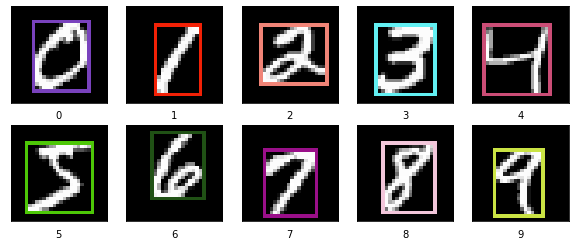

In [82]:
plot_mnist_objects_with_bbox(x_train,
                            y_train_bboxes,
                            label_color_map=rgb_dict_with_function)

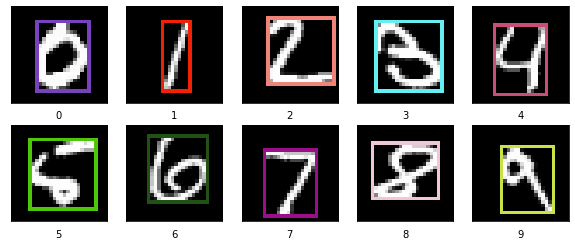

In [83]:
plot_mnist_objects_with_bbox(x_test,
                            y_test_bboxes,
                            label_color_map=rgb_dict_with_function)

In [84]:
np.where(y_test_bboxes[:, 0] == 0)[0][0]

3

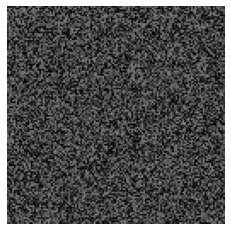

In [85]:
def generate_noise(size=(128, 128),
                   intensity = 128):
    # Generate a random array of shape size with values between 0 and 255
    random_image = np.random.randint(0, intensity, size, dtype=np.uint8)
    return random_image

# Generate a random 64x64 grayscale object
image = generate_noise()

# Display the object
plot_image_from_grayscale(image)

In [86]:
def choose_regions_to_populate(max_objects = 8,
                               grid_height = 4,
                               grid_width = 4):
    
    num_objects = np.random.choice(range(max_objects), 1)
    regions = np.random.choice(range(1, grid_width * grid_height + 1), 
                               num_objects, 
                               replace=False)
    return regions



In [87]:
def grab_x_bbox_region(object, 
                       label,
                       topleft_bottomright_coordinates=True):
    if topleft_bottomright_coordinates:
        x_min, y_min, x_max, y_max = label[1:]
    else:
        x_center, y_center, width, height = label[1:]
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
    # Upscale from normalized coordinates
    x_min = int(np.floor(x_min * object.shape[0]))
    y_min = int(np.floor(y_min * object.shape[1]))
    x_max = int(np.ceil(x_max * object.shape[0]))
    y_max = int(np.ceil(y_max * object.shape[1]))

    return object[x_min:x_max, y_min:y_max]

In [151]:
def add_object_to_image(image,
                        region_of_interest,
                        object,
                        label,
                        grid_height = 4,
                        grid_width = 4,
                        topleft_bottomright_coordinates=True):
    
    bbox_object = grab_x_bbox_region(object,
                                     label,
                                     topleft_bottomright_coordinates=topleft_bottomright_coordinates)
    
    region_y = int(image.shape[0] / grid_height)
    region_x = int(image.shape[1] / grid_width)

    x_center = np.random.randint(0, region_x + 1, 1)
    y_center = np.random.randint(0, region_y + 1, 1)

    x_center += (region_of_interest // grid_width) * region_x
    y_center += ((region_of_interest % grid_width) - 1) * region_y

    m, n = bbox_object.shape

    top = int((y_center - n // 2))
    left = int((x_center - m // 2))
    bottom = int(top + n)
    right = int(left + m)

    image[left:right, top:bottom] = np.maximum(image[left:right, top:bottom], bbox_object)

    image[image > 255] = 255

    return image


(17, 19)
70 50 89 67


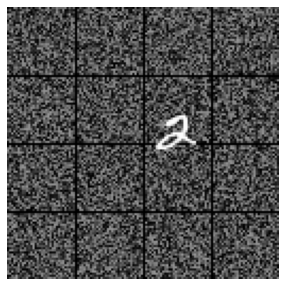

In [167]:
image = generate_noise(intensity = 150)
draw_grid_on_image(image, grid_height = 4, grid_width = 4)
image = add_object_to_image(image,
                    7,
                    x_train[5],
                    y_train_bboxes[5],
                    grid_height = 4,
                    grid_width = 4,
                    topleft_bottomright_coordinates=True)
plot_image_from_grayscale(image)